## Predicción y visualización de palabras basadas en el contexto con PCA

In [0]:
# Versión del lenguaje Python
from platform import python_version
print('Versión del lenguaje Python utilizada en este Jupyter Notebook:', python_version())

Versión del lenguaje Python utilizada en este Jupyter Notebook: 3.9.5


In [0]:
# Para actualizar un paquete, ejecute el siguiente comando en una terminal o símbolo del sistema:
# pip install -U nome_pacote

# Para instalar la versión exacta de un paquete, ejecute el siguiente comando en una terminal o símbolo del sistema:
# !pip install torch==1.5.0

# Después de instalar o actualizar el paquete, reinicie el cuaderno jupyter.

# Instale el paquete de marca de agua.
# Este paquete se usa para escribir versiones de otros paquetes usados ​​en este cuaderno jupyter.
!pip install -q -U watermark

# Instalar PyTorch
!pip install -q torch

# Paquete para gráficos con Scikit-learn
!pip install -q scikit-plot

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-80dd82d0-895b-49fd-a9d5-06b0a13519c0/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-80dd82d0-895b-49fd-a9d5-06b0a13519c0/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-80dd82d0-895b-49fd-a9d5-06b0a13519c0/bin/python -m pip install --upgrade pip' command.


In [0]:
# Imports
import torch
import scipy
import sklearn
import scikitplot
import numpy as np
import torch.nn.functional as F
from torch.optim import SGD
from torch.autograd import Variable, profiler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
from scikitplot.decomposition import plot_pca_2d_projection
%matplotlib inline

In [0]:
# Versiones de paquetes utilizados en este cuaderno jupyter
%reload_ext watermark
%watermark -a "Eric Passos" --iversions

Author: Eric Passos

scipy     : 1.7.1
sklearn   : 0.24.2
torch     : 1.12.1+cpu
numpy     : 1.20.3
scikitplot: 0.3.7



### Preparación de datos

In [0]:
# Corpus
corpus = ['ele é um rei',
          'ela é uma rainha',
          'ele é um homem',
          'ela é uma mulher',
          'Madrid é a capital da Espanha',
          'Berlim é a capital da Alemanha',
          'Lisboa é a capital de Portugal']

# # Construyendo vocabulario con tokenización
palavras = []
for sentence in corpus:
    for palavra in sentence.split():
         if palavra not in palavras:
            palavras.append(palavra)

# Visualizar los datos
#palavras

In [0]:
# Creamos la palabra - mapeo de índice
word2idx = {w:idx for (idx, w) in enumerate(palavras)}
#word2idx

# Creamos el índice de mapeo inverso - palabra
idx2word = {idx:w for (idx, w) in enumerate(palavras)}
#idx2word

In [0]:
# Tamaño del vocabulario
tamanho_vocab = len(word2idx)
tamanho_vocab

Out[8]: 19

### Construcción del modelo

In [0]:
# Función para generar las embeddings
def get_word_embedding(word):
    word_vec_one_hot = np.zeros(tamanho_vocab)
    word_vec_one_hot[word2idx[word]] = 1
    return word_vec_one_hot

# Función para generar los vectores, de la palabra central y del contexto
def gera_vetores():
    for sentence in corpus:
        words = sentence.split()
        indices = [word2idx[w] for w in words]
        
        # Bucle a través del rango de índice
        # Aquí generamos el vector de la palabra central en i
        # (daqui para frente somente comentários em Português)
        # E geramos o vetor de contexto
        for i in range(len(indices)):
            for w in range(-window_size, window_size + 1):
                context_idx = i + w
                if context_idx < 0 or context_idx >= len(indices) or i == context_idx:
                    continue
                    
                # Gera os vetores    
                center_vec_one_hot = np.zeros(tamanho_vocab)
                center_vec_one_hot[indices[i]] = 1
                context_idx = indices[context_idx]
                                
                yield center_vec_one_hot, context_idx

In [0]:
# Hiperparâmetros
embedding_dims = 10
window_size = 2

Definición de pesos de redes neuronales.
- W1 es una matriz de pesos de dimensión embedding_dims x tamanho_vocab
- W2 es una matriz de pesos de dimensión tamanho_vocab x embedding_dims

Los pesos (o coeficientes o parámetros) son lo que la red aprende durante el entrenamiento. Como al principio no sabemos el valor ideal de los pesos (esto es lo que queremos averiguar) empezamos con valores aleatorios usando torch.randn().

Al final del aprendizaje, el modelo en sí no es más que los valores ideales de W1 y W2.

In [0]:
# Definição dos pesos da rede neural
W1 = Variable(torch.randn(embedding_dims, tamanho_vocab).float(), requires_grad = True)
W2 = Variable(torch.randn(tamanho_vocab, embedding_dims).float(), requires_grad = True)

# Treinamento
print("\nIniciando o Treinamento...\n")
for epoch in range(1001):
    
    # Inicializa o erro médio da rede
    avg_loss = 0
    
    # Inicializa o controle do número de amostras
    samples = 0
    
    # Loop pelos dados (vetores de entrada)
    for data, target in gera_vetores():
        
        # Coleta x (vetor da palavra central)
        x = Variable(torch.from_numpy(data)).float()
        
        # Coleta y (vetor do contexto)
        y_true = Variable(torch.from_numpy(np.array([target])).long())
        
        # Atualiza o número de amostras
        samples += len(y_true)
        
        # Resultado da multiplicação entre os pesos e as primeiras camadas da rede
        a1 = torch.matmul(W1, x)
        a2 = torch.matmul(W2, a1)

        # A função softmax entrega a probabilidade da previsão da rede
        log_softmax = F.log_softmax(a2, dim = 0)

        # Previsão da rede
        network_pred_dist = F.softmax(log_softmax, dim = 0)
        
        # Calcula o erro, comparando a previsão da rede com o valor real 
        # (como fazemos em qualquer modelo de aprendizagem supervisionada)
        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        
        # Erro médio
        avg_loss += loss.item()
        
        # Inicia o backpropagation
        loss.backward()

        # Atualiza o valor dos pesos para a próxima passada
        W1.data -= 0.002 * W1.grad.data
        W2.data -= 0.002 * W2.grad.data

        # Zera o valor do gradiente depois de atualizar os pesos
        W1.grad.data.zero_()
        W2.grad.data.zero_()
        
    # Imprime o erro da rede
    if epoch % 10 == 0:
        print('Erro de Treinamento:', avg_loss / samples)

print("\nTreinamento Concluído.")


Iniciando o Treinamento...

Erro de Treinamento: 6.4481293912580675
Erro de Treinamento: 4.354798193307633
Erro de Treinamento: 3.6478042754721134
Erro de Treinamento: 3.2393978396628764
Erro de Treinamento: 2.9573072683303914
Erro de Treinamento: 2.745000735876408
Erro de Treinamento: 2.5758462808233626
Erro de Treinamento: 2.43539630161955
Erro de Treinamento: 2.316802277209911
Erro de Treinamento: 2.217510135883981
Erro de Treinamento: 2.1370442864742687
Erro de Treinamento: 2.0736552831974437
Erro de Treinamento: 2.0226839381329556
Erro de Treinamento: 1.97966827040023
Erro de Treinamento: 1.9421136303150908
Erro de Treinamento: 1.9087961461949856
Erro de Treinamento: 1.879022106845328
Erro de Treinamento: 1.8523121939060536
Erro de Treinamento: 1.8282851792396384
Erro de Treinamento: 1.806617337338468
Erro de Treinamento: 1.7870267775464566
Erro de Treinamento: 1.7692685463327043
Erro de Treinamento: 1.7531310034559129
Erro de Treinamento: 1.7384324758610827
Erro de Treinamento: 

### Pruebas de modelos y reducción de dimensionalidad con PCA

Para probar el modelo, todo lo que necesitamos son los pesos, en nuestro ejemplo W1 y W2. Pero visualizar los datos es un desafío ya que la dimensionalidad es alta y cuanto mayor es la cantidad de palabras de vocabulario, más complicado.

Una alternativa es reducir la dimensionalidad de los datos. Convertimos todos los atributos en 2 componentes principales usando PCA (Principal Component Analysis) y con 2 componentes podemos visualizar los datos.

Cada componente principal no es más que la combinación matemática de información en otras variables. PCA es un algoritmo de aprendizaje automático por derecho propio, de la categoría de aprendizaje no supervisado.

Apliquemos PCA para visualizar los datos.

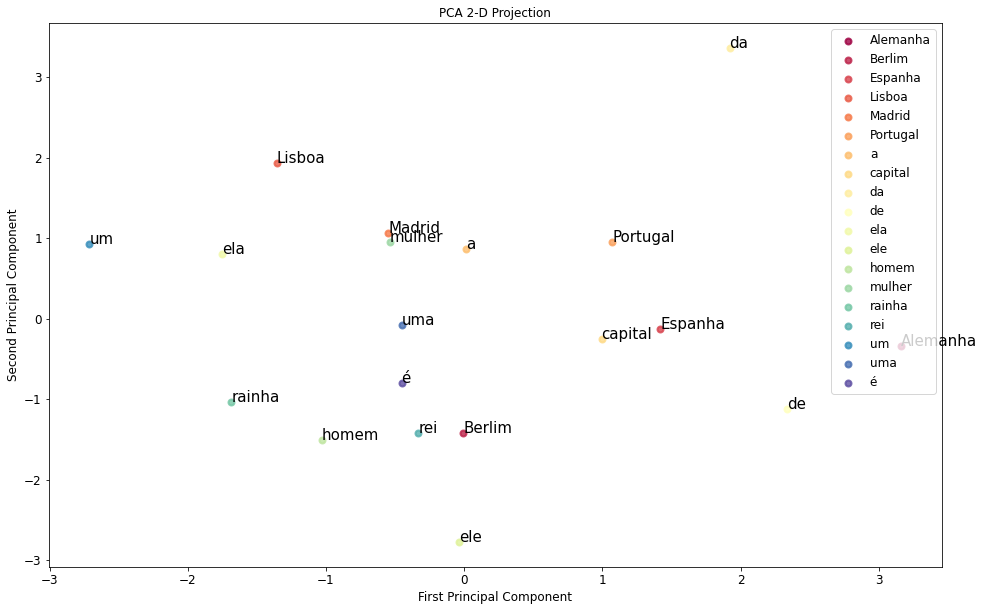

In [0]:
# Cria o objeto para redução de dimensionalidade
pca = PCA(n_components = 2)

# Treina o modelo PCA
pca.fit(W1.data.numpy().T)

# Calcula a projeção PCA para o Plot
proj = pca.transform(W1.data.numpy().T)

# Plot
ax = plot_pca_2d_projection(pca, 
                            W1.data.numpy().T, 
                            np.array(palavras), 
                            feature_labels = palavras, 
                            figsize = (16,10), 
                            text_fontsize = 12)

# Legenda
for i, txt in enumerate(palavras):
    ax.annotate(txt, (proj[i,0], proj[i,1]), size = 15)

¡Observe la leyenda en el gráfico de arriba! Las palabras similares basadas en el contexto están "punteadas" en colores similares. En la parte superior de la lista están los países y las ciudades, luego los pronombres y la palabra "capital", luego el hombre, la mujer, la reina y el rey, y finalmente los artículos y un verbo.

Todo esto lo aprendió la red en base al contexto, que no es más que la distancia del coseno entre las incrustaciones, los vectores que representan las palabras.

La visualización anterior muestra que las palabras que están en la misma dirección tienen cierta similitud, por ejemplo, "Alemania" y "Berlín". Dibuja una línea recta imaginaria que "corte" las palabras "Alemania" y "Berlín". Logra? Si la respuesta es sí, las palabras son similares. A continuación se muestra otro ejemplo.

Extraigamos las distancias basándonos en la pregunta:

**España es a Madrid lo que Alemania es a ?**

Preguntémosle al modelo.

In [0]:
# Função para obter um vetor de palavras no peso W1 (esse é o contexto)
def get_word_vector_v(word):
    return W1[:, word2idx[word]].data.numpy()

# Função para obter um vetor de palavras no peso W2 (essa é a palavra central)
def get_word_vector_u(word):
    return W2[word2idx[word],:].data.numpy()

# Vamos obter os vetores das palavras
espanha = 1 * get_word_vector_v('Espanha') + 1 * get_word_vector_u('Espanha')
alemanha = 1 * get_word_vector_v('Alemanha') + 1 * get_word_vector_u('Alemanha') 
madrid = 1 * get_word_vector_v('Madrid') + 1 * get_word_vector_u('Madrid')

# Resultado
resultado = madrid - espanha + alemanha

# Este é o resultado, ou seja, uma embedding que representa a palavra mais similar à palavra "Alemanha",
# com base na similaridade (contexto) entre "Polônia" e "Varsóvia".
resultado

Out[13]: array([-1.4957035 ,  2.9762697 , -0.22803485, -3.236721  , -0.83437204,
        0.2375148 ,  4.275031  ,  0.39417887,  1.2541492 ,  2.0929558 ],
      dtype=float32)

In [0]:
# Vamos extrair as distâncias de todas as outras palavras para a nossa palavra "secreta" que está 
# no vetor embedding chamado "resultado"
# Usamos a função cosine() do SciPy para calcular as distâncias
distancias = [(v, cosine(resultado, 1 * get_word_vector_u(v) + 1 * get_word_vector_v(v))) for v in palavras]

# Visualiza as distâncias
distancias

Out[14]: [('ele', 1.124088615179062),
 ('é', 0.6856277287006378),
 ('um', 1.4345101714134216),
 ('rei', 1.5316073894500732),
 ('ela', 0.7210364043712616),
 ('uma', 0.7048457860946655),
 ('rainha', 0.9631597511470318),
 ('homem', 1.1097887605428696),
 ('mulher', 1.2006993889808655),
 ('Madrid', 0.19002974033355713),
 ('a', 0.2693604826927185),
 ('capital', 0.7435624897480011),
 ('da', 0.7924654185771942),
 ('Espanha', 1.2620294690132141),
 ('Berlim', 0.3496047258377075),
 ('Alemanha', 0.485362708568573),
 ('Lisboa', 0.6760610044002533),
 ('de', 0.8173457980155945),
 ('Portugal', 0.9434079714119434)]

Arriba tenemos una lista de tuplas con las distancias de cada palabra para nuestro "resultado". Ordenemos esto.

In [0]:
# Ordenando a lista de tuplas pelo segundo elemento da tupla
distancias.sort(key = lambda tup: tup[1])

# Agora sim
distancias

Out[15]: [('Madrid', 0.19002974033355713),
 ('a', 0.2693604826927185),
 ('Berlim', 0.3496047258377075),
 ('Alemanha', 0.485362708568573),
 ('Lisboa', 0.6760610044002533),
 ('é', 0.6856277287006378),
 ('uma', 0.7048457860946655),
 ('ela', 0.7210364043712616),
 ('capital', 0.7435624897480011),
 ('da', 0.7924654185771942),
 ('de', 0.8173457980155945),
 ('Portugal', 0.9434079714119434),
 ('rainha', 0.9631597511470318),
 ('homem', 1.1097887605428696),
 ('ele', 1.124088615179062),
 ('mulher', 1.2006993889808655),
 ('Espanha', 1.2620294690132141),
 ('um', 1.4345101714134216),
 ('rei', 1.5316073894500732)]

El vector "resultado" fue una predicción de nuestro modelo y las palabras "Madrid" y "Berlín" son las más similares. Tenga en cuenta que "Berlín" es la palabra más similar según el contexto, ya que Madrid ya se usó en nuestra fórmula.

Imagina que un vector (una flecha) parte del origen del sistema de coordenadas (Honestidad = 0 y Experiencia = 0, lo llamaremos punto O) y termina en el punto X. Este vector se usa para ubicar el punto en nuestra característica espacio. No es diferente a simplemente decir que X tiene H = 0.4 y E = 0.2, es solo otra forma de verlo.

![cos](https://user-images.githubusercontent.com/97414922/236580548-cccafda6-fabd-4a49-8fdd-cd4e32db454b.png)

Si sabemos cuál es el ángulo entre los vectores X y A, podemos usar una calculadora simple y calcular la similitud. Podemos ver en la imagen de arriba que los vectores de X y A están en la misma línea recta (observe los colores de los círculos en la leyenda), por lo que el ángulo entre ellos es de cero grados y su similitud es cos(0) = 1 .semejanza entre X y B no sabemos el ángulo y necesitamos usar una ecuación. El numerador (la parte superior de la división) significa multiplicar los valores de Honestidad X y B y sumar con la multiplicación de los valores Experiencia X y B.

Eso es lo que hace Word2vec. Brillante, ¿no?

**¿En qué contexto aparece la palabra Lisboa?**

Aquí es como si estuviéramos usando el modelo para la predicción.

In [0]:
# Extrai o contexto
context_to_predict = get_word_vector_v('Lisboa')

# Variável com o contexto a prever
hidden = Variable(torch.from_numpy(context_to_predict)).float()

# Executa o modelo e extrai as probabilidades 
# (executar o modelo nada mais é do que multiplicar os novos dados de entrada pelos pesos aprendidos no treinamento)
a = torch.matmul(W2, hidden)
probs = F.softmax(a, dim = 0).data.numpy()

# Imprime o resultado
for context, prob in zip(palavras, probs):
    print(f'{context}: {prob}')

ele: 0.0028529553674161434
é: 0.48537003993988037
um: 1.615015571587719e-05
rei: 0.0025090354029089212
ela: 0.0001439100451534614
uma: 0.0006580750923603773
rainha: 0.00012043897004332393
homem: 0.0003027277998626232
mulher: 7.115796961443266e-06
Madrid: 0.004290546290576458
a: 0.4954136908054352
capital: 2.9249453291413374e-05
da: 0.00027194686117582023
Espanha: 0.0014903655974194407
Berlim: 0.0005157387931831181
Alemanha: 0.0037149344570934772
Lisboa: 0.00022301971330307424
de: 0.0019152986351400614
Portugal: 0.00015486172924283892


El contexto de la palabra "Lisboa" está representado por las palabras "é", "a", "Portugal".

Nuestro modelo no pudo aprender el contexto "capital". Tal vez pueda optimizar el entrenamiento del modelo y aumentar su precisión.

# Fin